![Astrofisica Computacional](../../../logo.png)

---
## 04. Linear Regression Algorithm with a Numerical Gradient


Eduard Larrañaga (ealarranaga@unal.edu.co)

---


### About this notebook

In this worksheet, we implement an algorithm of linear regression using an optimization procedure based on a numerical gradient.

---

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import ascii

import pandas as pd
%matplotlib inline

# No warnings
import warnings
warnings.filterwarnings('ignore')

### Green and Ho data

Consider the dataset reported by Greene and Ho (2006), containing the features of 88 galaxies. 

Greene, J. E. and Ho, L. C. *The MBH − σ∗ Relation in Local Active Galaxies*. ApJ 641 L21 (2006)
https://ui.adsabs.harvard.edu/abs/2006ApJ...641L..21G/abstract

The dataset is available online in various formats at

http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/ApJ/641/L21.


In [12]:
data = ascii.read('data/table1.dat', readme='data/ReadMe')
df = data.to_pandas()
df

,Name,z,sigma*,e_sigma*,n_sigma*,FWHM,e_FWHM,logL,e_logL,logM,E_logM,e_logM
0,SDSS J000805.62+145023.4,0.045400,140.0,27.0,NaN,7610,380,41.13,0.04,7.70,NaN,0.10
1,SDSS J004236.86-104921.8,0.041900,78.4,10.0,NaN,1960,97,41.58,0.14,6.70,NaN,0.10
2,SDSS J011703.58+000027.3,0.045600,98.8,16.0,NaN,2270,110,41.45,0.08,6.80,NaN,0.10
3,SDSS J020459.25-080816.0,0.077200,121.0,9.4,a,3720,180,41.13,0.05,7.00,NaN,0.10
4,SDSS J020615.99-001729.1,0.042600,216.0,30.0,NaN,3860,190,41.91,0.07,7.50,NaN,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...
83,NGC 4151,0.003320,96.8,2.9,NaN,<NA>,<NA>,NaN,NaN,6.91,0.17,0.29
84,NGC 5548,0.017200,198.0,11.0,NaN,<NA>,<NA>,NaN,NaN,7.81,0.02,0.02
85,NGC 7469,0.016300,133.0,4.8,NaN,<NA>,<NA>,NaN,NaN,6.49,0.16,0.27
86,POX 52,0.021800,36.0,5.0,NaN,<NA>,<NA>,NaN,NaN,5.20,NaN,0.30


We will make a linear fit between the variables $\log M$ and $\log \left( \frac{\sigma_*}{\sigma_0} \right)$ and between the varibles $\log M$ and $\log  \text{FWHM} $, where $\sigma_0 = 200.$ is a reference value given by the authors. Hence, we add the corresponding columns to the dataframe.

In [13]:
sigma0 = 200.
df['logsigma*'] = np.log10(df['sigma*']/sigma0)
df['logFWHM'] = np.log10(df['FWHM'])
df.describe()

,z,sigma*,e_sigma*,FWHM,e_FWHM,logL,e_logL,logM,E_logM,e_logM,logsigma*,logFWHM
count,88.000000,88.000000,88.000000,71.0,71.0,71.000000,71.000000,88.00000,15.000000,88.000000,88.000000,71.0
mean,0.048665,117.142045,11.805682,3206.056338,210.760563,41.504225,0.078028,6.86625,0.140667,0.189886,-0.272206,3.440999
std,0.032562,48.285108,5.308383,1759.679743,191.219953,0.663268,0.041700,0.72825,0.074303,0.172470,0.195820,0.246118
min,0.000947,30.000000,2.900000,810.0,41.0,40.100000,0.030000,4.90000,0.020000,0.020000,-0.823909,2.908485
25%,0.027750,87.025000,7.750000,1905.0,110.0,41.155000,0.050000,6.30000,0.100000,0.100000,-0.361386,3.279893
50%,0.042250,113.500000,12.000000,2970.0,160.0,41.510000,0.070000,7.00000,0.120000,0.100000,-0.246038,3.472756
75%,0.062200,139.250000,15.000000,3870.0,210.0,41.860000,0.090000,7.40750,0.170000,0.200000,-0.157237,3.58771
max,0.184000,268.000000,30.000000,8240.0,1190.0,43.610000,0.200000,8.52000,0.310000,1.060000,0.127105,3.915927


In [14]:
newdf = df[['logM','logsigma*','logFWHM']]
newdf = newdf.apply (pd.to_numeric, errors='coerce')
newdf = newdf.dropna()
newdf.describe()

,logM,logsigma*,logFWHM
count,71.000000,71.000000,71.0
mean,6.819718,-0.286024,3.440999
std,0.660653,0.176979,0.246118
min,5.100000,-0.744727,2.908485
25%,6.300000,-0.380551,3.279893
50%,6.900000,-0.255707,3.472756
75%,7.300000,-0.161151,3.58771
max,8.200000,0.077368,3.915927


In [15]:
X_train = np.asarray(newdf[['logsigma*']])
y_train = np.asarray(newdf[['logM']])

print('Xdf shape : ', X_train.shape)
print('ydf shape : ', y_train.shape)

Xdf shape :  (71, 1)
ydf shape :  (71, 1)


### Linear Regression

Since the plot of the logarithm of the velocity vs. apparent magnitude has a linear tendence, we will create a linear regression for this data.

The goal of the following algorithm is to minimize the *cost function*

\begin{equation}
f_c(\{a_j\}) = \sum_{i=1}^N \left( Y(x_i,\{a_j\}) - y_i \right)^2\,\,
\end{equation}

where

\begin{equation}
Y(x, \{w,b\}) =  w x + b\,\,.
\end{equation}

### Gradient Descent

The minimization will be done by using the numerical gradient of the cost function with respect to the parameters $w$ and $b$.

We also introduce a learning rate to reach the minimum of the cost function.

<img src="GradientDescent.png" />





In [16]:
class LinearRegression():
    '''
    Linear regression class
    '''
    def __init__(self):
        # Initial random parameters
        np.random.seed(413)
        self.W = np.random.rand() 
        self.b = np.random.rand()

    def predict(self, X):
        '''
        Function to fit
        '''
        return self.W*X + self.b
    
    def cost(self, X, y):
        '''
        Cost function
        '''
        delta = self.predict(X) - y
        return np.sum(delta**2)
    
    def grad_cost(self, X, y):
        '''
        Numerical Gradient of the cost function
        '''
        grad_dW, grad_db = self.numGrad(X, y)
        return grad_dW, grad_db
    
    def fit(self, X, y):
        '''
        Optimization function
        '''
        alpha= 0.0001 # Learning rate
        tol = 1e-13 # Tolerance

        self.history = []
        self.history.append(self.cost(X, y))
        print('Initial cost = ', self.history[0])
        
        epoch = 0 # Epochs
        epsilon = 1
        while epsilon>tol and epoch<250000:
            # Gradients
            grad_dW, grad_db = self.grad_cost(X,y)
            self.W = self.W - alpha*grad_dW
            self.b = self.b - alpha*grad_db
            
            self.history.append(self.cost(X, y))
            epsilon = abs(self.history[epoch] - self.history[epoch+1])
            epoch +=1
        
        print('Final cost = ', self.history[-1])
        print('Number of epochs = ',epoch)
        return self.W, self.b
    
    def score(self, X, y):
        '''
        R^2 coefficient
        '''
        n = len(y)
        mean_y = (1/n)*np.sum(y)
        numer = np.sum((self.predict(X) - y)**2)
        denom = np.sum((y-mean_y)**2)
        return 1 - numer/denom
    
    def numGrad(self, X, y):
        '''
        Numerical gradient using central finite
        differences.
        '''
        Wrem = self.W
        brem = self.b
        dW, db = 1e-8, 1e-8
        self.W = Wrem - dW
        fcW1 = self.cost(X,y) 
        self.W = Wrem + dW
        fcW2 = self.cost(X,y)
        self.W = Wrem
        self.b = brem - dW
        fcb1 = self.cost(X,y)
        self.b = brem + dW
        fcb2 = self.cost(X,y)
        self.b = brem
        grad_dW = (fcW2 - fcW1)/(2*dW)
        grad_db = (fcb2 - fcb1)/(2*db)
        return grad_dW, grad_db
      

In [17]:
lr = LinearRegression()

W, b = lr.fit(X_train, y_train)

print('\nThe optimized parameters are')
print('W = ',W)
print('b = ',b)

Initial cost =  3137.6271124417235
Final cost =  14.534929309696883
Number of epochs =  32446

The optimized parameters are
W =  2.702865503922307
b =  7.592801365591144


In [18]:
lr.score(X_train,y_train)

0.5242621859523338

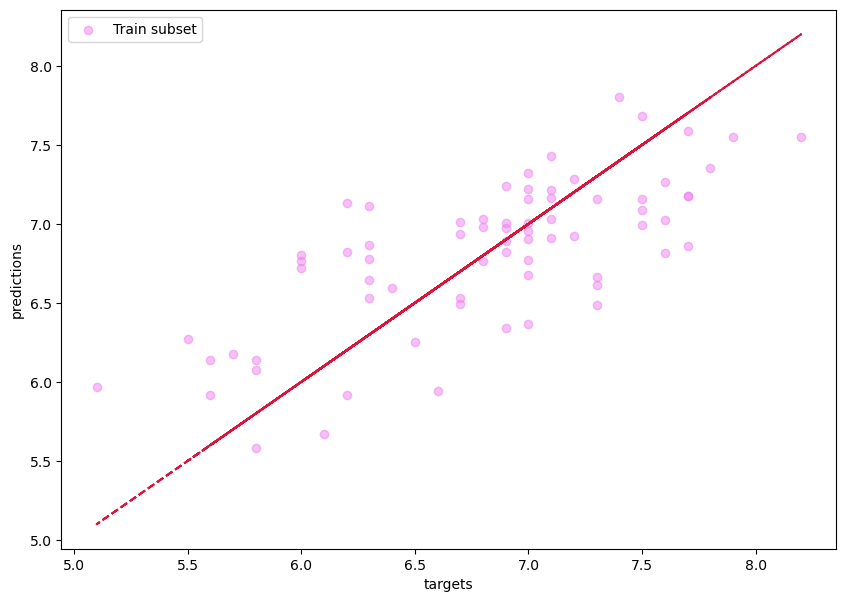

In [19]:
# Plot
predictions = lr.predict(X_train)

plt.figure(figsize=(10,7))
plt.scatter(y_train, predictions, alpha=0.5, color='violet', label='Train subset')
plt.plot(y_train, y_train, '--', color='crimson')
plt.ylabel(r'predictions')
plt.xlabel(r'targets')
plt.legend()
plt.show()

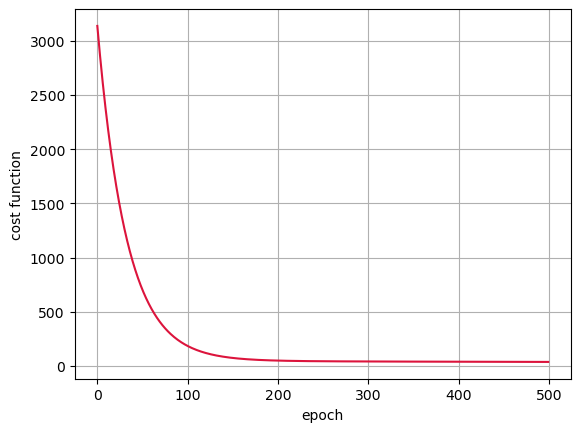

In [10]:
# Plot Training history

plt.figure()
plt.plot(lr.history[0:500], color='crimson')
plt.ylabel(r'cost function')
plt.xlabel(r'epoch')
plt.grid()
plt.show()